In [9]:
# install.packages("SparseM", type = "source")
# install.packages("MatrixModels", type = "source")


In [4]:
install.packages("xgboost")
install.packages("glmnet")
install.packages("ranger")
install.packages("vip")



In [5]:
# rm(list = ls())   # wipe workspace CLEAN

library(tidymodels)
library(dplyr)
library(tidyverse)
library(xgboost)
library(yardstick)
library(vip)
library(jsonlite)
library(glmnet)
library(ranger)
library(quantreg)

── Attaching packages ───────────────────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.11     ✔ recipes      1.3.1 
✔ dials        1.4.2      ✔ rsample      1.3.1 
✔ dplyr        1.1.4      ✔ tailor       0.1.0 
✔ ggplot2      4.0.1      ✔ tidyr        1.3.1 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.4.0      ✔ workflowsets 1.1.1 
✔ purrr        1.2.0      ✔ yardstick    1.3.2 

── Conflicts ──────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()

── Attaching core tidyverse packages ─────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ readr     2.1.6     
── Conflicts ────────────────────────────────────────────────

In [6]:
training_df <- read_csv("../../../MIMIC_ED/processed/los_training_df.csv")

head(training_df)


Rows: 421233 Columns: 15
── Column specification ───────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race, disposition, icd_code, icd_title
dbl (9): stay_id, subject_id, hadm_id, ed_los_hours, acuity, medication_coun...
lgl (1): is_admitted

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


stay_id,subject_id,hadm_id,gender,race,ed_los_hours,acuity,is_admitted,disposition,medication_count,hosp_los_hours,log_hosp_los_hours,icd_code,icd_version,icd_title
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
30000012,11714491,21562392,F,WHITE,5.616667,2,TRUE,ADMITTED,14,65.00000,4.174387,5722,9,HEPATIC ENCEPHALOPATHY
30000012,11714491,21562392,F,WHITE,5.616667,2,TRUE,ADMITTED,14,65.00000,4.174387,5990,9,URIN TRACT INFECTION NOS
30000038,13821532,26255538,F,WHITE,3.300000,3,TRUE,ADMITTED,12,45.61667,3.820273,J189,10,"PNEUMONIA, UNSPECIFIED ORGANISM"
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,80709,9,FX MULT RIBS NOS-CLOSED
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,8054,9,FX LUMBAR VERTEBRA-CLOSE
30000039,13340997,23100190,M,WHITE,8.516667,3,TRUE,ADMITTED,4,46.76667,3.845171,8052,9,FX DORSAL VERTEBRA-CLOSE


In [7]:
set.seed(123)

data_split <- initial_split(training_df, prop = 0.8)
train <- training(data_split)
val  <- testing(data_split)


In [35]:
train <- train %>%
  group_by(stay_id) %>%
  summarize(across(everything(), first)) 
val <- val %>%
  group_by(stay_id) %>%
  summarize(across(everything(), first)) 


# Model v3 - Quantile Regression

Since the LOS data is extremely skewed, we want to 

In [36]:
simplify_race <- function(r) {
  r <- toupper(as.character(r))
  
  if (grepl("WHITE", r)) {
    "WHITE"
  } else if (grepl("BLACK", r) || grepl("AFRICAN", r)) {
    "BLACK"
  } else if (grepl("HISPANIC", r) || grepl("LATINO", r)) {
    "HISPANIC"
  } else if (grepl("ASIAN", r)) {
    "ASIAN"
  } else if (grepl("NATIVE", r) || grepl("PACIFIC", r) || grepl("ALASKA", r)) {
    "NATIVE/PI"
  } else {
    "OTHER"
  }
}

# Vectorized version for use inside recipes
simplify_race_vec <- function(r) {
  sapply(r, simplify_race)
}

In [63]:
los_recipe <- recipe(log_hosp_los_hours ~ acuity + race + gender + ed_los_hours + medication_count, 
                     data = train) %>%
  
  # Simplify race and convert to factor
  step_mutate(
    race = factor(simplify_race_vec(race))
  ) %>%
  
  
  # Interaction features
  step_mutate(
    acuity_ed = acuity * ed_los_hours,
    meds_per_hour = medication_count / (ed_los_hours + 0.01)
  ) %>%
  
  # Dummy encode
  step_dummy(all_nominal_predictors()) %>%
  
  # Remove zero-variance predictors
  step_zv(all_predictors())


In [64]:
# 1. Preprocess train data with your recipe
prepped_train <- prep(los_recipe) %>% bake(new_data = train)

# 2. Define quantiles
taus <- c(0.1, 0.5, 0.9)

# 3. Fit a model for each quantile
quant_fits <- lapply(taus, function(tau_val) {
  rq(log_hosp_los_hours ~ ., data = prepped_train, tau = tau_val)
})

names(quant_fits) <- paste0("tau_", taus)

# 4. Preprocess test data
prepped_test <- prep(los_recipe) %>% bake(new_data = val)

# 5. Make predictions
preds_list <- lapply(quant_fits, function(mod) {
  predict(mod, newdata = prepped_test)
})

preds_df <- as.data.frame(preds_list)
colnames(preds_df) <- paste0("LOS_tau_", taus)

# Optional: add stay_id
preds_df <- cbind(val %>% select(stay_id), preds_df) %>%
  mutate(across(starts_with("LOS_tau"), exp))

head(preds_df)

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”


,stay_id,LOS_tau_0.1,LOS_tau_0.5,LOS_tau_0.9
,<dbl>,<dbl>,<dbl>,<dbl>
1,30000012,15.171293,82.18987,254.1683
2,30000177,16.453303,89.85617,312.2088
3,30000204,8.505923,41.90025,174.6718
4,30000279,7.181813,22.81199,146.2331
5,30000368,10.105961,69.46118,264.4929
6,30000527,7.623028,63.13033,233.4463


In [67]:
# preds_df <- read_csv("../../results/qr_predictions.csv")


In [68]:
preds_df$truth <- val$hosp_los_hours
write.csv(preds_df, "../../results/qr_predictions.csv", row.names = FALSE)


In [70]:
summary(preds_list[[1]])

range(preds_list[[1]])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9678  2.1432  2.3721  2.4304  2.6425 14.0561 

[1]  0.9678068 14.0561178

Lets cap los stays

In [71]:
preds_df <- preds_df %>%
  mutate(
    LOS_tau_0.1 = pmin(LOS_tau_0.1, 200),
    LOS_tau_0.5 = pmin(LOS_tau_0.5, 500),
    LOS_tau_0.9 = pmin(LOS_tau_0.9, 2000)
  )

In [72]:
head(preds_df, 5)

,stay_id,LOS_tau_0.1,LOS_tau_0.5,LOS_tau_0.9,truth
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30000012,15.171293,82.18987,254.1683,65.000000
2,30000177,16.453303,89.85617,312.2088,37.266667
3,30000204,8.505923,41.90025,174.6718,7.083333
4,30000279,7.181813,22.81199,146.2331,10.116667
5,30000368,10.105961,69.46118,264.4929,71.433333


In [73]:
summary(preds_df)

    stay_id          LOS_tau_0.1       LOS_tau_0.5      LOS_tau_0.9       
 Min.   :30000012   Min.   :  2.632   Min.   :  0.00   Min.   :  0.04079  
 1st Qu.:32522214   1st Qu.:  8.527   1st Qu.: 43.04   1st Qu.:175.59662  
 Median :35004170   Median : 10.720   Median : 58.91   Median :214.12260  
 Mean   :35007408   Mean   : 12.819   Mean   : 60.82   Mean   :220.81892  
 3rd Qu.:37496349   3rd Qu.: 14.049   3rd Qu.: 75.16   3rd Qu.:258.06536  
 Max.   :39999939   Max.   :200.000   Max.   :423.51   Max.   :769.65114  
     truth          
 Min.   :   0.0333  
 1st Qu.:  20.3333  
 Median :  58.2083  
 Mean   :  99.5433  
 3rd Qu.: 118.7500  
 Max.   :5990.0500  

#### What it means:
theres a 10% chance the LOS for this patient will be above ____ and a 90% chance it'll be under ___

    stay_id          LOS_tau_0.1       LOS_tau_0.5      LOS_tau_0.9       
 Min.   :30000012   Min.   :  2.632   Min.   :  0.00   Min.   :  0.04079  
 1st Qu.:32522214   1st Qu.:  8.527   1st Qu.: 43.04   1st Qu.:175.59662  
 Median :35004170   Median : 10.720   Median : 58.91   Median :214.12260  
 Mean   :35007408   Mean   : 12.819   Mean   : 60.82   Mean   :220.81892  
 3rd Qu.:37496349   3rd Qu.: 14.049   3rd Qu.: 75.16   3rd Qu.:258.06536  
 Max.   :39999939   Max.   :200.000   Max.   :423.51   Max.   :769.65114  
     truth          
 Min.   :   0.0333  
 1st Qu.:  20.3333  
 Median :  58.2083  
 Mean   :  99.5433  
 3rd Qu.: 118.7500  
 Max.   :5990.0500  

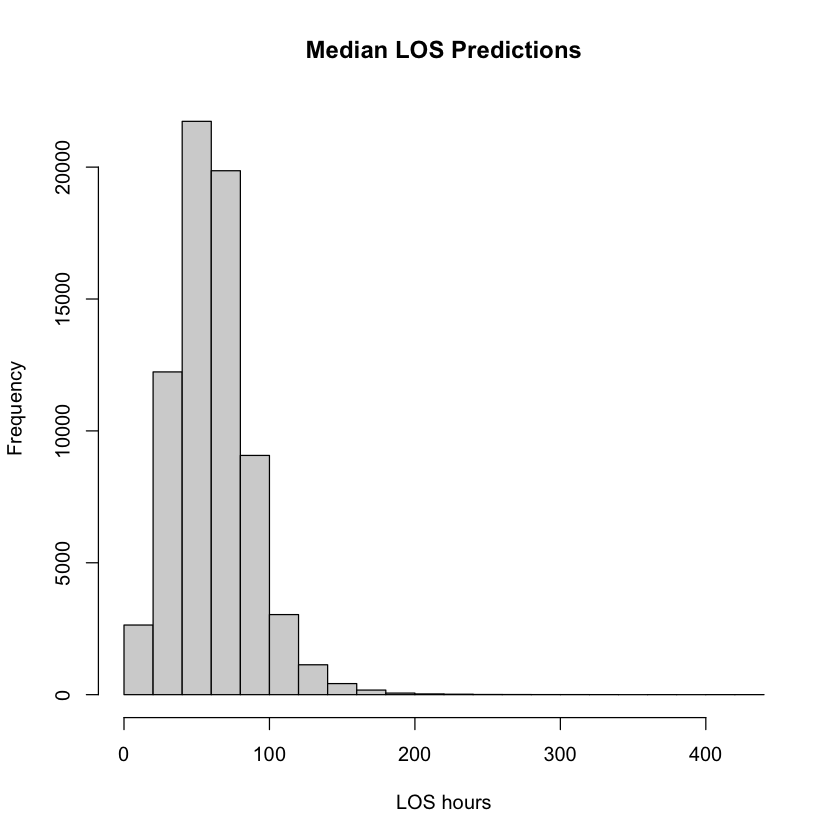

In [74]:
summary(preds_df)
hist(preds_df$LOS_tau_0.5, main="Median LOS Predictions", xlab="LOS hours")


In [75]:
mean(val$hosp_los_hours <= preds_df$LOS_tau_0.1)  # should be ~0.1
mean(val$hosp_los_hours <= preds_df$LOS_tau_0.5)  # should be ~0.5
mean(val$hosp_los_hours <= preds_df$LOS_tau_0.9)  # should be ~0.9


[1] 0.1077716

[1] 0.5105344

[1] 0.9042819

## Evaluating QuantReg with Pinball Loss

In [76]:
pinball_loss <- function(y_true, y_pred, tau) {
  res <- y_true - y_pred
  mean(ifelse(res >= 0, tau * res, (tau - 1) * res))
}

# Compute losses
results <- data.frame(
  model = c("Baseline (Median)", "Quantile τ=0.1", "Quantile τ=0.5", "Quantile τ=0.9"),
  tau   = c(0.5, 0.1, 0.5, 0.9),
  pinball_loss = c(
    pinball_loss(val$hosp_los_hours, rep(median(train$hosp_los_hours), nrow(val)), 0.5),
    pinball_loss(val$hosp_los_hours, preds_df$LOS_tau_0.1, 0.1),
    pinball_loss(val$hosp_los_hours, preds_df$LOS_tau_0.5, 0.5),
    pinball_loss(val$hosp_los_hours, preds_df$LOS_tau_0.9, 0.9)
  )
)

print(results)


              model tau pinball_loss
1 Baseline (Median) 0.5    37.772127
2    Quantile τ=0.1 0.1     9.299892
3    Quantile τ=0.5 0.5    35.162453
4    Quantile τ=0.9 0.9    30.387654


In [77]:
median(val$hosp_los_hours)

[1] 58.20833

In [78]:
coverage_10_90 <- mean(
  val$hosp_los_hours >= preds_df$LOS_tau_0.1 & 
  val$hosp_los_hours <= preds_df$LOS_tau_0.9
)

coverage_10_90

[1] 0.7965671

In ~80.16% of patients, the true LOS fell inside the predicted 10–90% interval.

# Comparing Quantile Regression to Ensemble Model (pinball loss)

In [79]:
ensemble_results <- read_csv('../../results/ensemble_predictions_vs_truth.csv')

head(ensemble_results, 3)

Rows: 84247 Columns: 2
── Column specification ───────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): pred_hours, truth_hours

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pred_hours,truth_hours
<dbl>,<dbl>
82.85071,65.00000
67.97708,37.26667
67.97708,37.26667


In [80]:


# compute pinball loss for ensemble at tau=0.5
ensemble_pinball_0.5 <- pinball_loss(
  ensemble_results$truth_hours,
  ensemble_results$pred_hours,
  tau = 0.5
)

ensemble_pinball_0.5


[1] 31.72808

In [81]:
quantile_pinball_0.5 <- pinball_loss(val$hosp_los_hours, preds_df$LOS_tau_0.5, 0.5)

comparison <- data.frame(
  model = c("Quantile Regression (τ=0.5)", "Ensemble"),
  tau = c(0.5, 0.5),
  pinball_loss = c(quantile_pinball_0.5, ensemble_pinball_0.5)
)

print(comparison)


                        model tau pinball_loss
1 Quantile Regression (τ=0.5) 0.5     35.16245
2                    Ensemble 0.5     31.72808


Ensemble is better for point prediction

QR is better for uncertainty quantification

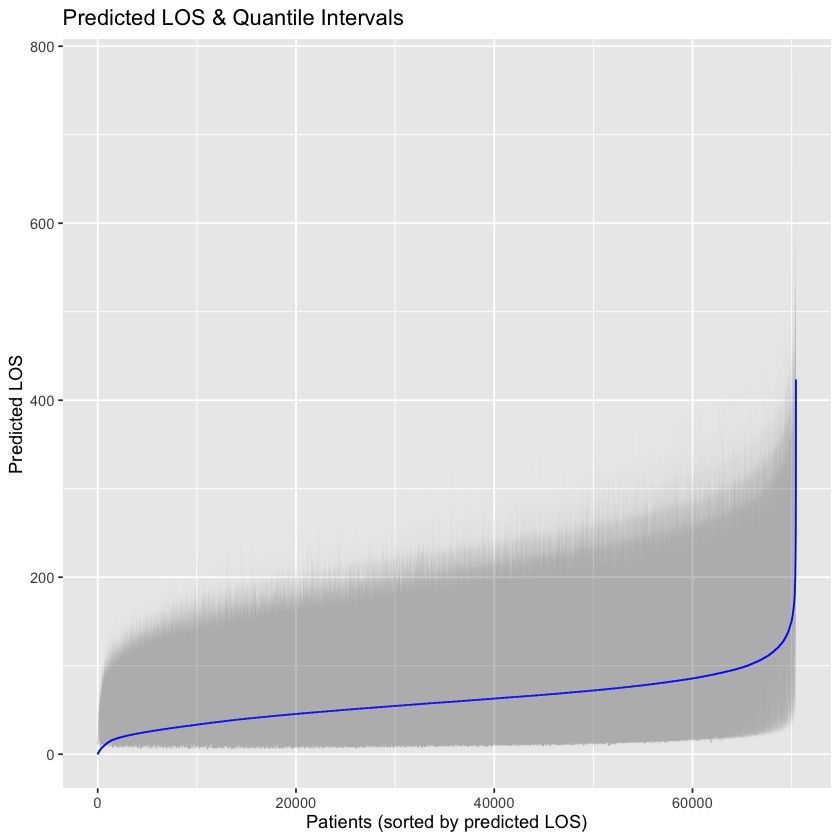

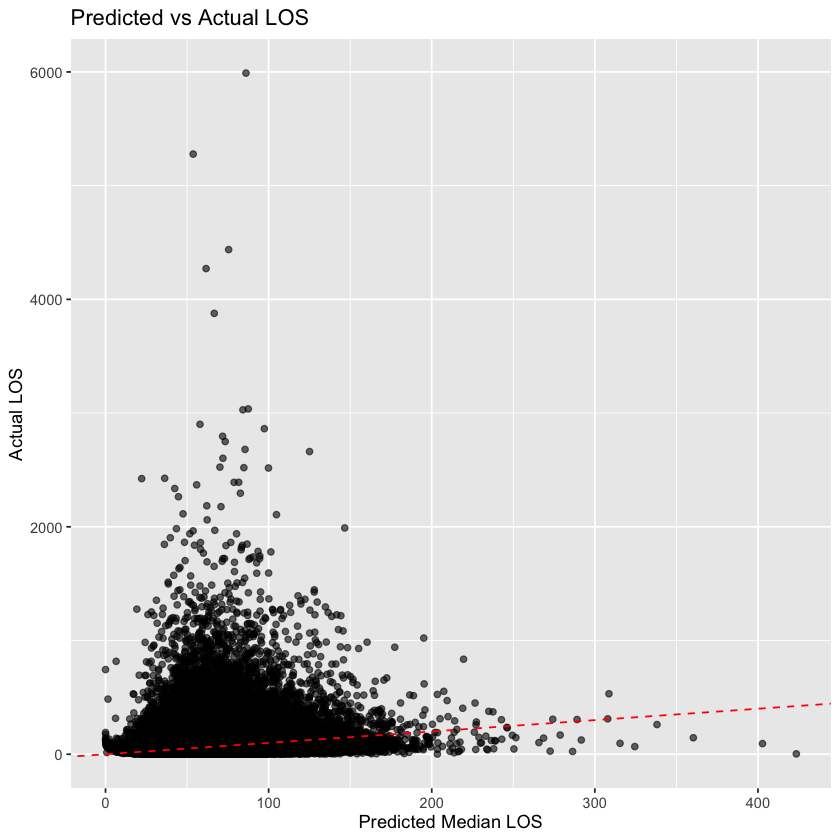

In [92]:
# Plot 1: Prediction intervals (sorted by predicted median)
plot_df_sorted <- preds_df %>%
  arrange(LOS_tau_0.5) %>%
  mutate(idx = row_number())

ggplot(plot_df_sorted, aes(x = idx)) +
  geom_ribbon(aes(ymin = LOS_tau_0.1, ymax = LOS_tau_0.9), alpha = 0.3) +
  geom_line(aes(y = LOS_tau_0.5), color = "blue") +
  labs(title = "Predicted LOS & Quantile Intervals", x = "Patients (sorted by predicted LOS)", y = "Predicted LOS")

# Plot 2: Predicted vs actual LOS
ggplot(preds_df, aes(x = LOS_tau_0.5, y = truth)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Predicted vs Actual LOS", x = "Predicted Median LOS", y = "Actual LOS")


In [26]:
head(preds_df)
summary(preds_df)
summary(val$hosp_los_hours)

,stay_id,LOS_tau_0.1,LOS_tau_0.5,LOS_tau_0.9,truth
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30000012,13.400673,79.23296,247.4552,65.000000
2,30000177,14.926891,86.19963,307.1693,37.266667
3,30000177,14.926891,86.19963,307.1693,37.266667
4,30000204,7.797382,39.48439,168.8010,7.083333
5,30000204,7.797382,39.48439,168.8010,7.083333
6,30000279,7.474139,21.84566,140.9482,10.116667


    stay_id          LOS_tau_0.1         LOS_tau_0.5       LOS_tau_0.9       
 Min.   :30000012   Min.   :      2.2   Min.   :   0.00   Min.   :3.984e-02  
 1st Qu.:32525014   1st Qu.:      8.0   1st Qu.:  40.63   1st Qu.:1.699e+02  
 Median :35016741   Median :     10.1   Median :  56.41   Median :2.087e+02  
 Mean   :35012103   Mean   :    105.8   Mean   :  58.69   Mean   :2.155e+02  
 3rd Qu.:37492477   3rd Qu.:     13.0   3rd Qu.:  72.81   3rd Qu.:2.529e+02  
 Max.   :39999939   Max.   :3824181.2   Max.   :1583.09   Max.   :1.456e+03  
     truth          
 Min.   :   0.0333  
 1st Qu.:  20.1000  
 Median :  57.2167  
 Mean   :  99.4295  
 3rd Qu.: 118.9333  
 Max.   :5990.0500  

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   0.0333   20.1000   57.2167   99.4295  118.9333 5990.0500 